### Практическая работа №1: Поиск частых наборов

Выполнил: Чашин Денис, ЕТ-128

In [10]:
import warnings
warnings.filterwarnings("ignore")

import time
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
import math


In [7]:
path = "baskets.csv"

SUPPORTS = [0.01, 0.03, 0.05, 0.10, 0.15, 0.20]
MAX_LEN = 7

ROUND_SUPPORT = 6

In [8]:
# Чтение данных
df = pd.read_csv(path, header=None, encoding='cp1251')

# строка - корзина
transactions = []
for _, row in df.iterrows():
    items = [str(x).strip() for x in row.dropna().tolist() if str(x).strip() != ""]
    transactions.append(sorted(set(items)))

n = len(transactions)
print("Transactions:", n)
print("Example:", transactions[0:5])

Transactions: 7501
Example: [['авокадо', 'батат', 'замороженный смузи', 'зеленый виноград', 'зеленый чай', 'креветки', 'лосось', 'мед', 'миндаль', 'минеральная вода', 'низкокалорийный йогурт', 'овощная смесь', 'оливковое масло', 'салат', 'творог', 'томатный сок', 'цельнозерновая мука', 'шпинат', 'энергетический напиток', 'ягодный сок'], ['гамбургер', 'фрикадельки', 'яйца'], ['чатни'], ['авокадо', 'индейка'], ['зеленый чай', 'минеральная вода', 'молоко', 'рис', 'энергетический батончик']]


In [9]:
# one-hot преобразование транзакций

te = TransactionEncoder()
onehot = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
print("One-hot:", onehot.shape)

One-hot: (7501, 115)


In [11]:
def eclat_onehot(df_onehot, min_support, max_len=7):
    N = len(df_onehot)
    min_count = int(np.ceil(min_support * N))

    # вертикальный формат: item -> tidset
    tidset = {}
    for col in df_onehot.columns:
        t = set(df_onehot.index[df_onehot[col] == 1])
        if len(t) >= min_count:
            tidset[frozenset([col])] = t

    out = {}

    base = sorted(tidset.items(), key=lambda x: (len(x[1]), list(x[0])[0]))

    def dfs(prefix_items, prefix_tids, start):
        for i in range(start, len(base)):
            itemset_i, tids_i = base[i]

            new_items = prefix_items | itemset_i
            if len(new_items) > max_len:
                continue

            new_tids = tids_i if prefix_tids is None else (prefix_tids & tids_i)
            cnt = len(new_tids)

            if cnt >= min_count:
                out[new_items] = cnt / N
                dfs(new_items, new_tids, i + 1)

    dfs(frozenset(), None, 0)
    return out

In [12]:
def run_apriori(df_onehot, min_support, max_len=7):
    t0 = time.perf_counter()
    res = apriori(df_onehot, min_support=min_support, use_colnames=True, max_len=max_len)
    dt = time.perf_counter() - t0
    d = {frozenset(it): float(sup) for it, sup in zip(res["itemsets"], res["support"])}
    return d, dt

def run_fpgrowth(df_onehot, min_support, max_len=7):
    t0 = time.perf_counter()
    res = fpgrowth(df_onehot, min_support=min_support, use_colnames=True, max_len=max_len)
    dt = time.perf_counter() - t0
    d = {frozenset(it): float(sup) for it, sup in zip(res["itemsets"], res["support"])}
    return d, dt

def run_eclat(df_onehot, min_support, max_len=7):
    t0 = time.perf_counter()
    d = eclat_onehot(df_onehot, min_support=min_support, max_len=max_len)
    dt = time.perf_counter() - t0
    return d, dt

In [13]:
def normalize(d, round_digits=6):
    return {k: round(v, round_digits) for k, v in d.items()}

def same_results(d1, d2):
    a = normalize(d1, ROUND_SUPPORT)
    b = normalize(d2, ROUND_SUPPORT)
    return a == b

In [17]:
summary = []
all_results = {}

def length_distribution(itemset_dict):
    c = defaultdict(int)
    for it in itemset_dict.keys():
        c[len(it)] += 1
    return dict(c)

for s in SUPPORTS:
    ap, ap_t = run_apriori(onehot, s, MAX_LEN)
    fp, fp_t = run_fpgrowth(onehot, s, MAX_LEN)
    ec, ec_t = run_eclat(onehot, s, MAX_LEN)

    all_results[("Apriori", s)] = ap
    all_results[("FP-Growth", s)] = fp
    all_results[("ECLAT", s)] = ec

    summary.append({
        "support": s,

        "ap_time": ap_t, "fp_time": fp_t, "ec_time": ec_t,
        "ap_count": len(ap), "fp_count": len(fp), "ec_count": len(ec),

        "ap_maxlen": max((len(k) for k in ap.keys()), default=0),
        "fp_maxlen": max((len(k) for k in fp.keys()), default=0),
        "ec_maxlen": max((len(k) for k in ec.keys()), default=0),

        "same_ap_fp": same_results(ap, fp),
        "same_ap_ec": same_results(ap, ec),
        "same_fp_ec": same_results(fp, ec),

        "ap_len_dist": length_distribution(ap),
        "fp_len_dist": length_distribution(fp),
        "ec_len_dist": length_distribution(ec),
    })

df_sum = pd.DataFrame(summary)
print(df_sum[[
    "support",
    "ap_time","fp_time","ec_time",
    "ap_count","fp_count","ec_count",
    "ap_maxlen","fp_maxlen","ec_maxlen",
    "same_ap_fp","same_ap_ec","same_fp_ec"
]])


   support   ap_time   fp_time   ec_time  ap_count  fp_count  ec_count  \
0     0.01  0.173143  0.077093  0.031966       261       261       261   
1     0.03  0.039883  0.126193  0.060517        55        55        55   
2     0.05  0.020872  0.084585  0.059601        28        28        28   
3     0.10  0.005296  0.043510  0.023674         7         7         7   
4     0.15  0.004090  0.030086  0.023900         5         5         5   
5     0.20  0.002360  0.028388  0.019144         1         1         1   

   ap_maxlen  fp_maxlen  ec_maxlen  same_ap_fp  same_ap_ec  same_fp_ec  
0          3          3          3        True        True        True  
1          2          2          2        True        True        True  
2          2          2          2        True        True        True  
3          1          1          1        True        True        True  
4          1          1          1        True        True        True  
5          1          1          1        T

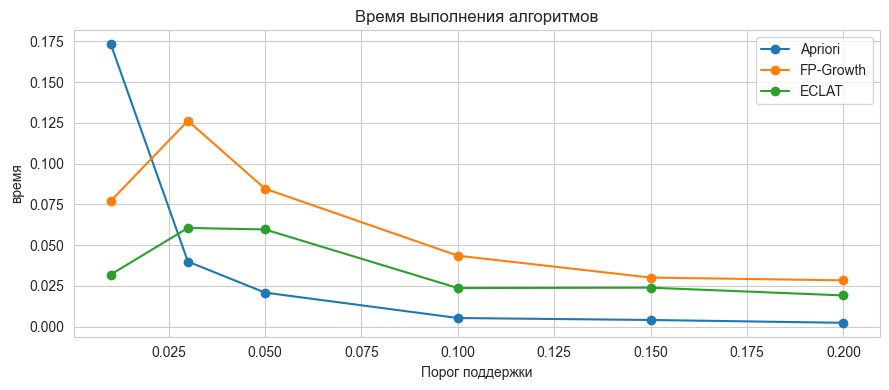

In [25]:
x = df_sum["support"].values

# (1) время
plt.figure(figsize=(9,4))
plt.plot(x, df_sum["ap_time"], marker="o", label="Apriori")
plt.plot(x, df_sum["fp_time"], marker="o", label="FP-Growth")
plt.plot(x, df_sum["ec_time"], marker="o", label="ECLAT")
plt.xlabel("Порог поддержки")
plt.ylabel("время")
plt.title("Время выполнения алгоритмов")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

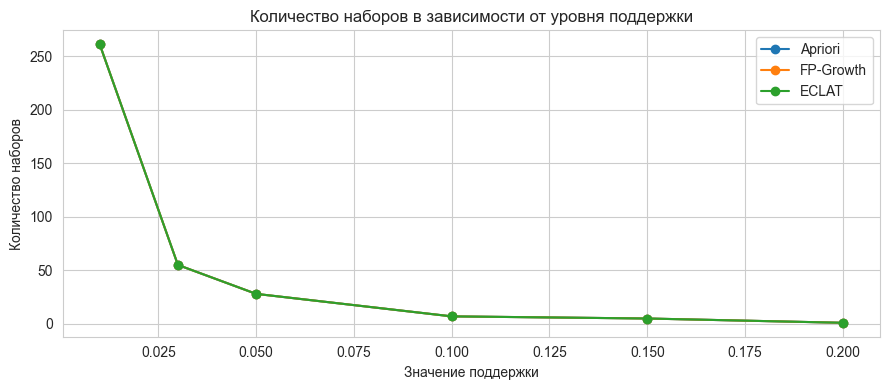

In [26]:
# количество частых наборов
plt.figure(figsize=(9,4))
plt.plot(x, df_sum["ap_count"], marker="o", label="Apriori")
plt.plot(x, df_sum["fp_count"], marker="o", label="FP-Growth")
plt.plot(x, df_sum["ec_count"], marker="o", label="ECLAT")
plt.xlabel("Значение поддержки")
plt.ylabel("Количество наборов")
plt.title("Количество наборов в зависимости от уровня поддержки")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

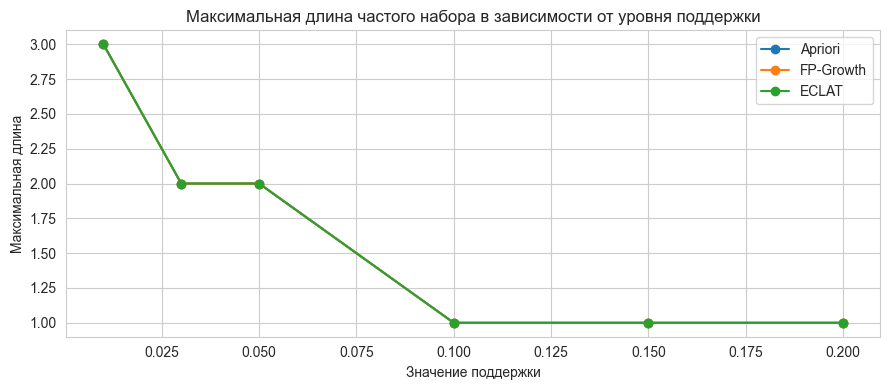

In [27]:
# (3) максимальная длина набора
plt.figure(figsize=(9,4))
plt.plot(x, df_sum["ap_maxlen"], marker="o", label="Apriori")
plt.plot(x, df_sum["fp_maxlen"], marker="o", label="FP-Growth")
plt.plot(x, df_sum["ec_maxlen"], marker="o", label="ECLAT")
plt.xlabel("Значение поддержки")
plt.ylabel("Максимальная длина")
plt.title("Максимальная длина частого набора в зависимости от уровня поддержки")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# количество наборов разных длин при изменяемом support
def plot_len_vs_support(col_dist, alg_name):
    lengths = range(1, MAX_LEN+1)
    mat = []
    for d in df_sum[col_dist]:
        mat.append([d.get(L, 0) for L in lengths])
    mat = np.array(mat)

    plt.figure(figsize=(9,4))
    for i, L in enumerate(lengths):
        plt.plot(x, mat[:, i], marker="o", label=f"len={L}")
    plt.xlabel("Значения поддержки")
    plt.ylabel("Количество наборов")
    plt.title(f"Распределение частых наборов в зависимости от значения поддержки ({alg_name})")
    plt.grid(True)
    plt.legend(ncol=4, fontsize=8)
    plt.tight_layout()
    plt.show()

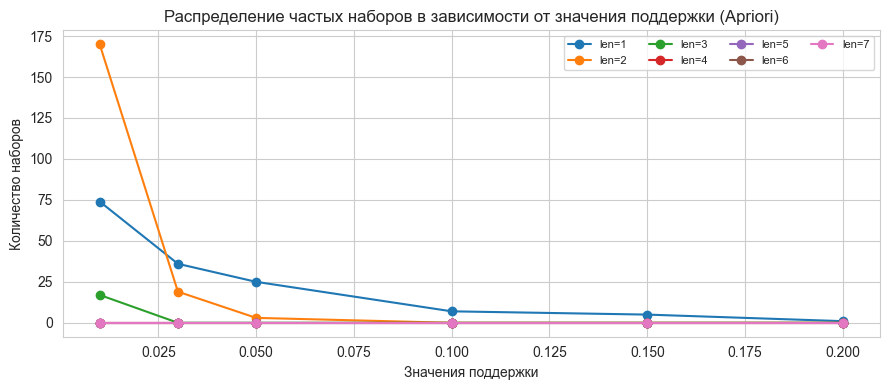

In [29]:
plot_len_vs_support("ap_len_dist", "Apriori")

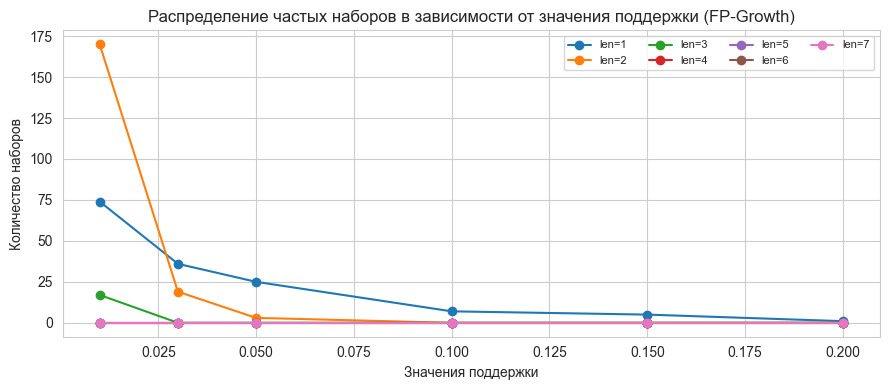

In [30]:
plot_len_vs_support("fp_len_dist", "FP-Growth")

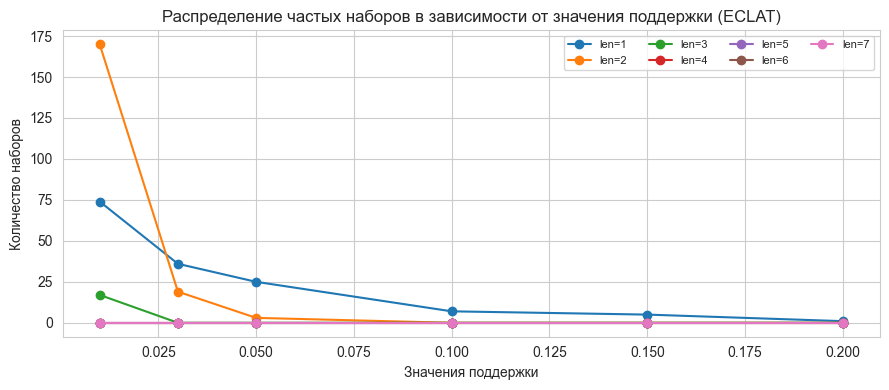

In [32]:
plot_len_vs_support("ec_len_dist", "ECLAT")